In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import pickle
from SimDataScraper import *

In [ ]:
# OPENING THE MINMAX DATASET NOT INCLUDING NEW MEASUREMENTS

with open(".\\DatasetFragments\\first\\MinMaxDataset\\Subset\\MinMaxDumpFile", 'rb+') as datasetFile:
    dataset = pickle.load(datasetFile)


#TEMP BUG FIX: Must repeat the SID 10 times for each Tc step
#TODO REAL BUG IN THE DATASCRAPER 
SIDLIST = []
for SID in dataset.rawDict["SID"]:
    SIDLIST.extend([SID] * 10)

dataset.rawDict["SID"] = SIDLIST
dataset.SimDict["SID"] = SIDLIST
del SIDLIST


# Add in post-processed dictonaries
with open(".\\DatasetFragments\\first\\MinMaxDataset\\Subset\\MinMaxSlew", 'rb+') as datasetFile:
    compressedDict = pickle.load(datasetFile)

for SID in dataset.rawDict["SID"]:
    index = compressedDict["SID"].index(SID)

    for key in compressedDict:
        if key == "SID":
            continue
        dataset.rawDict.setdefault(key, []).append(compressedDict[key][index])
del compressedDict


with open(".\\DatasetFragments\\first\\MinMaxDataset\\Subset\\MinMaxVdson", 'rb+') as datasetFile:
    compressedDict = pickle.load(datasetFile)

for SID in dataset.rawDict["SID"]:
    index = compressedDict["SID"].index(SID)

    for key in compressedDict:
        if key == "SID":
            continue
        dataset.rawDict.setdefault(key, []).append(compressedDict[key][index])
del compressedDict


with open(".\\DatasetFragments\\first\\MinMaxDataset\\Subset\\MinMaxPhase", 'rb+') as datasetFile:
    compressedDict = pickle.load(datasetFile)

for SID in dataset.rawDict["SID"]:
    index = compressedDict["SID"].index(SID)

    for key in compressedDict:
        if key == "SID":
            continue
        dataset.rawDict.setdefault(key, []).append(compressedDict[key][index])
del compressedDict


# Add additional rows by transforming existing data
dataset.rawDict["zvs_t_true"] = [x > 0 for x in dataset.rawDict["zvs_t"]]
dataset.rawDict["zvs_b_true"] = [x > 0 for x in dataset.rawDict["zvs_b"]]

dataset.rawDict["esr_series_lumped"] = [x + y for x,y in zip(dataset.rawDict["Cs_ESR"], dataset.rawDict["Ls_ESR"])]

dataset.rawDict["tank_p_avg_loss"] = [-x - y - w - z for x,y,w,z in zip(dataset.rawDict["p_in_avg"], dataset.rawDict["p_out_avg"], dataset.rawDict["p_sw_avg_t"], dataset.rawDict["p_sw_avg_t"])]

In [3]:
# OPENING THE FIRST DATASET NOT INCLUDING NEW MEASUREMENTS

preDir = ".\\DatasetFragments\\"
folderNames = ["first\\OverMaxDataset\\Subset", "second\\OverMaxDataset\\Subset"]
fileNamePrefix = ["Interpolation", "Interpolation"]
datasetList = [None] * len(folderNames)

for i in range(len(folderNames)):
    dirPath = preDir + folderNames[i]+ "\\"

    with open(dirPath + fileNamePrefix[i] + "DumpFile", 'rb+') as datasetFile:
        datasetInterp = pickle.load(datasetFile)


    #TEMP BUG FIX: Must repeat the SID 10 times for each Tc step
    #TODO REAL BUG IN THE DATASCRAPER 
    SIDLIST = []
    for SID in datasetInterp.rawDict["SID"]:
        SIDLIST.extend([SID] * 10)

    datasetInterp.rawDict["SID"] = SIDLIST
    datasetInterp.SimDict["SID"] = SIDLIST
    del SIDLIST


    # Add in post-processed dictonaries

    with open(dirPath + fileNamePrefix[i] + "Slew", 'rb+') as datasetFile:
        compressedDict = pickle.load(datasetFile)

    for SID in datasetInterp.rawDict["SID"]:
        index = compressedDict["SID"].index(SID)

        for key in compressedDict:
            if key == "SID":
                continue
            datasetInterp.rawDict.setdefault(key, []).append(compressedDict[key][index])
    del compressedDict


    with open(dirPath + fileNamePrefix[i] + "Vdson", 'rb+') as datasetFile:
        compressedDict = pickle.load(datasetFile)

    for SID in datasetInterp.rawDict["SID"]:
        index = compressedDict["SID"].index(SID)

        for key in compressedDict:
            if key == "SID":
                continue
            datasetInterp.rawDict.setdefault(key, []).append(compressedDict[key][index])
    del compressedDict


    with open(dirPath + fileNamePrefix[i] + "Phase", 'rb+') as datasetFile:
        compressedDict = pickle.load(datasetFile)

    for SID in datasetInterp.rawDict["SID"]:
        index = compressedDict["SID"].index(SID)

        for key in compressedDict:
            if key == "SID":
                continue
            datasetInterp.rawDict.setdefault(key, []).append(compressedDict[key][index])
    del compressedDict



    # Add additional rows by transforming existing data
    datasetInterp.rawDict["zvs_t_true"] = [x > 0 for x in datasetInterp.rawDict["zvs_t"]]
    datasetInterp.rawDict["zvs_b_true"] = [x > 0 for x in datasetInterp.rawDict["zvs_b"]]

    datasetInterp.rawDict["esr_series_lumped"] = [x + y for x,y in zip(datasetInterp.rawDict["Cs_ESR"], datasetInterp.rawDict["Ls_ESR"])]

    datasetInterp.rawDict["tank_p_avg_loss"] = [-x - y - w - z for x,y,w,z in zip(datasetInterp.rawDict["p_in_avg"], datasetInterp.rawDict["p_out_avg"], datasetInterp.rawDict["p_sw_avg_t"], datasetInterp.rawDict["p_sw_avg_t"])]

    datasetList[i] = datasetInterp


dataset = datasetList[0]
for i in range(1, len(datasetList)):
    dataset.MergeDataset(datasetList[i])


In [ ]:
# FILTER DATA OUTSIDE RANGE (accidently expanded the ranges too far for a simulation batch)
varNames = ["Cs",         "Ls",           "Lp",           "Cs_ESR",    "Ls_ESR", "Lp_ESR", "Cdc_ESR",   "Vin",      "Rdson_T", "Rdson_B", "Cds_T", "Cds_B",  "Cgs_T",   "Cgs_B"]
varMaxes =   [239e-9 * 1.5, 10.58e-6 * 1.5, 105.8e-6 * 1.5, 20e-3 * 1.25, 75e-3,    75e-3,    10e-3 * 1.2, 800 * 1.25, 50e-3,     50e-3,    105e-12, 105e-12, 2550e-12, 2550e-12]

for i in range(len(varNames)):
    varName = varNames[i]
    varMax = varMaxes[i]

    print(len(dataset.rawDict["Cs"]))
    badCount  = np.count_nonzero([i for i in dataset.rawDict[varName] if i > varMax])
    print("Bad: %d (%0.2f%%)" % (badCount, 100.0 * badCount / len(dataset)))

    i = 0
    while i < len(dataset.rawDict[varName]):
        x = dataset.rawDict[varName][i]
        if x > varMax:
            for key in dataset.rawDict:
                del dataset.rawDict[key][i]
        else:
            i += 1

print(len(dataset.rawDict["Cs"]))

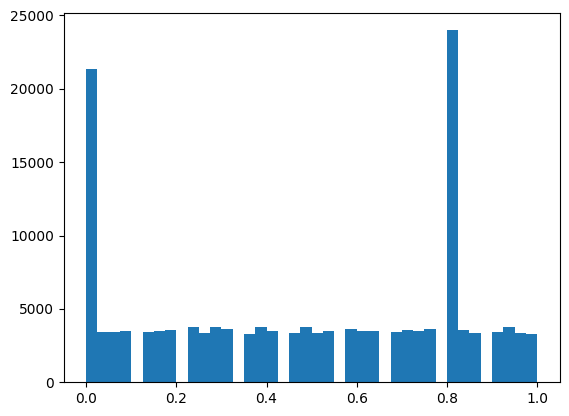

In [4]:
# Checking the distribution of the dataset with a histogram
import matplotlib.pyplot as plt
plt.hist(dataset.SimDict["Cs"], 40)
plt.show()

In [ ]:
# Write the dataset to a seralized file
with open(".\\MedRangedDataset", 'wb+') as datasetFile:
    pickle.dump(dataset, datasetFile)

In [ ]:
# Test to make sure the seralized file can be read 
import pickle

fileName = ".\\DatasetFragments\\first\\MinMaxDataset\\Subset\\MinMaxPhase"
with open(fileName, 'rb+') as dataFile:
    readDataset = pickle.load(dataFile)

#print(len(readDataset["SID"]))
#print(len(readDataset["v_ds_on_max_t"]))

for key in readDataset:
    print(key, end=': ')
    print(readDataset[key][:10])

# for key in readDataset.rawDict:
#     print(key, end=": ")
#     print(readDataset.rawDict[key][:10])

del readDataset

In [ ]:
# For testing how different datasets overlap or not

import pickle

with open(".\\OverMax_LargeDataset", 'rb+') as dataFile:
    mainSet = pickle.load(dataFile)

with open(".\\DatasetSlices\\Additional\\First\\InterpolationDumpFile", 'rb+') as dataFile:
    firstSet = pickle.load(dataFile)

with open(".\\DatasetSlices\\Additional\\Null\\InterpolationDumpFile", 'rb+') as dataFile:
    nullSet = pickle.load(dataFile)

with open(".\\DatasetSlices\\Additional\\Second\\InterpolationDumpFile", 'rb+') as dataFile:
    secondSet = pickle.load(dataFile)

with open(".\\DatasetSlices\\InterpolationDataset\\InterpolationDumpFile", 'rb+') as dataFile:
    firstBig = pickle.load(dataFile)

with open(".\\DatasetSlices\\InterpolationDataset\\InterpolationDumpFile_1", 'rb+') as dataFile:
    secondBig = pickle.load(dataFile)\
    
with open(".\\DatasetSlices\\MinMax\\DumpFile", 'rb+') as dataFile:
    mimmax = pickle.load(dataFile)

In [ ]:
DATASETS = []
PATH = "DatasetFragments\\first\\InRangeDataset\\"
PF = ["DumpFile", "Slew", "Vdson", "Phase"]

for i in range(len(PF)):
    print(".\\" + PATH + "Interpolation" + PF[i])
    with open(".\\" + PATH + "Interpolation" + PF[i], 'rb+') as dataFile:
        DATASETS.append(pickle.load(dataFile))
print()

PATH = "DatasetFragments\\first\\MinMaxDataset\\"
PF = ["DumpFileTest", "SlewCompressedDict", "VdsonCompressDict"]
for i in range(len(PF)):
    print(".\\" + PATH + PF[i])
    with open(".\\" + PATH + PF[i], 'rb+') as dataFile:
        DATASETS.append(pickle.load(dataFile))
print()

PATH = "DatasetFragments\\first\\MinMaxDataset\\Subset\\"
PF = ["DumpFile", "Slew", "Vdson", "Phase", "Charge"]
for i in range(len(PF)):
    print(".\\" + PATH + "MinMax" + PF[i])
    with open(".\\" + PATH + "MinMax" + PF[i], 'rb+') as dataFile:
        DATASETS.append(pickle.load(dataFile))
print()

PATH = "DatasetFragments\\first\\OverMaxDataset\\"
PF = ["DumpFile", "Slew", "Vdson", "Phase"]
for i in range(len(PF)):
    print(".\\" + PATH + "Interpolation" + PF[i])
    with open(".\\" + PATH + "Interpolation" + PF[i], 'rb+') as dataFile:
        DATASETS.append(pickle.load(dataFile))
print()

PATH = "DatasetFragments\\second\\OverMaxDataset\\Subset\\"
PF = ["DumpFile", "Slew", "Vdson", "Phase"]
for i in range(len(PF)):
    print(".\\" + PATH + "Interpolation" + PF[i])
    with open(".\\" + PATH + "Interpolation" + PF[i], 'rb+') as dataFile:
        DATASETS.append(pickle.load(dataFile))
print()


In [ ]:
SIDS =  DATASETS[16].rawDict["SID"] #firstSet.rawDict["SID"] + nullSet.rawDict["SID"] + secondSet.rawDict["SID"] + mimmax.rawDict["SID"] + firstBig.rawDict["SID"] + secondBig.rawDict["SID"]
TRUE_SIDS = DATASETS[12].rawDict["SID"]

piecesLen = len(set(SIDS))
trueLen= len(set(TRUE_SIDS))

print("Pieces Length: %d" % piecesLen)
print("True Length: %d\n" % trueLen)

print("Combined Length: %d" % (piecesLen + trueLen))

uniqueCount = len(set(SIDS + TRUE_SIDS))
print("Unique Length: %d \tOverlapping: %d" % (uniqueCount, piecesLen + trueLen - uniqueCount))